In [8]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from theano.tensor.nnet import conv2d
from theano.tensor.signal import downsample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [4]:
def draw_sample_image(X,Y):
    labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    X, Y = shuffle(X, Y)
    for i in xrange(20):
        plt.subplot(4,5,i)
        img = X[i]
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[Y[i]])
    plt.show()

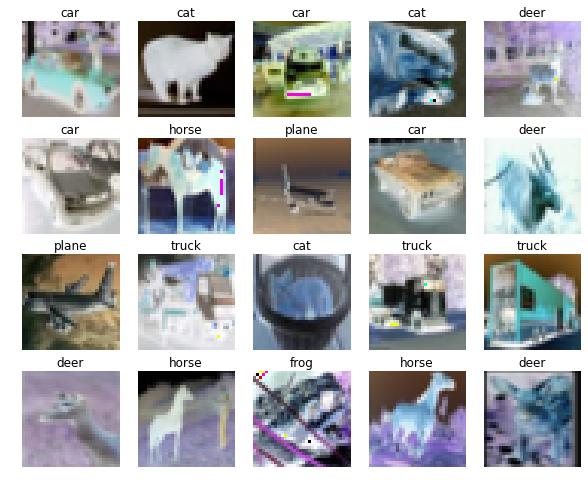

In [5]:
draw_sample_image(X_train,y_train)

In [6]:
def rearrange(X):
    N = X.shape[0]
    X_out = np.zeros((N,3,32,32),dtype=np.float32)
    for i in xrange(N):
        for j in xrange(3):
            X_out[i,j,:,:] = X[i,:,:,j]
    return X_out / 255

In [7]:
X_train = rearrange(X_train)
X_test = rearrange(X_test)

In [9]:
def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1,M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

In [10]:
def init_filter(shape,poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)

In [11]:
def error_rate(Y,T):
    return np.mean(Y!=T)

In [12]:
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,int(y[i])] = 1
    return y_ind

In [13]:
class HidenLayer(object):
    def __init__(self,M1,M2,an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1,M2)
        self.W = theano.shared(W,'W_%s' % self.id)
        self.b = theano.shared(b,'b_%s' % self.id)
        self.params = [self.W,self.b]
    def forward(self,X):
        return T.nnet.relu(X.dot(self.W) + self.b)

In [14]:
class ConvPoolLayer(object):
    def __init__(self,mi,mo,fw=5,fh=5,poolsz=(2,2)):
        sz = (mo,mi,fw,fh)
        W0 = init_filter(sz,poolsz)
        self.W = theano.shared(W0)
        b0 = np.zeros(mo,dtype=np.float32)
        self.b = theano.shared(b0)
        self.poolsz = poolsz
        self.params = [self.W,self.b]
    def forward(self,X):
        conv_out = conv2d(input=X,filters=self.W)
        pool_out = downsample.max_pool_2d(
            input=conv_out,
            ds=self.poolsz,
            ignore_border=True
        )
        return T.nnet.relu(pool_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [15]:
class CNN(object):
    def __init__(self,convpool_layer_sizes,hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
    def train(self, X, Y, lr=10e-5, mu=0.99, reg=10e-7, decay=0.99999, eps=10e-3, batch_sz=300, epochs=50, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        eps = np.float32(eps)
        
        #make validation set 
        X,Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        X,Y = X[:-1000], Y[:-1000]
        X_valid, Y_valid = X[-1000:], Y[-1000:]
        Y_ind = y2indicator(Y)
        Y_valid_ind = y2indicator(Y_valid)
        #initialize convpool layers 
        N,c, width, height = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo,fw,fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi,mo,fw,fh)
            self.convpool_layers.append(layer)
            outw = (outw - fw + 1) / 2
            outh = (outh - fh + 1) / 2
            mi = mo 
        #initialize the fully connected layers
        K = len(set(Y))
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HidenLayer(M1,M2,count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        # logistic regression layer 
        W, b = init_weight_and_bias(M1,K)
        self.W = theano.shared(W,'W_logreg')
        self.b = theano.shared(b,'b_logreg')
        
        # collect params for latter use 
        self.params = [self.W,self.b]
        for c in self.convpool_layers:
            self.params += c.params
        for h in self.hidden_layers:
            self.params + h.params
        # for momentum 
        dparams = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        cache = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        # setup theano functions and variables 
        th_X = T.tensor4('X',dtype='float32')
        th_Y = T.matrix('Y')
        P_Y = self.forward(th_X)
        rcost = T.sum([(p*p).sum() for p in self.params])
        cost = -(th_Y*T.log(P_Y)).sum() + rcost
        prediction = self.predict(th_X)
        cost_prediction_op = theano.function(
            inputs = [th_X,th_Y],
            outputs = [cost,prediction]
        )
        # updates 
        updates = [
            (p, p + mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ] + [
            (dp, mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ]
        train_op = theano.function(
            inputs = [th_X,th_Y],
            updates = updates
        )
        n_batches = N / batch_sz
        costs = []
        for i in xrange(epochs):
            for j in xrange(n_batches):
                X_batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Y_batch = Y_ind[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(X_batch,Y_batch)
                if j % 20 == 0:
                    c,p = cost_prediction_op(X_valid,Y_valid_ind)
                    costs.append(c)
                    e = error_rate(Y_valid,p)
                    print "i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e
        if show_fig:
            plt.plot(costs)
            plt.show()
    def forward(self,X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z = Z.flatten(ndim=2)
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)
    def predict(self,X):
        P_Y = self.forward(X)
        return T.argmax(P_Y,axis=1)

i: 0 j: 0 nb: 163 cost: 2347.28540635 error rate: 0.898
i: 0 j: 20 nb: 163 cost: 2330.73200679 error rate: 0.869
i: 0 j: 40 nb: 163 cost: 2234.37440515 error rate: 0.821
i: 0 j: 60 nb: 163 cost: 2182.63497889 error rate: 0.795
i: 0 j: 80 nb: 163 cost: 2123.90912914 error rate: 0.776
i: 0 j: 100 nb: 163 cost: 2073.81972472 error rate: 0.765
i: 0 j: 120 nb: 163 cost: 1974.0147658 error rate: 0.726
i: 0 j: 140 nb: 163 cost: 1915.55725488 error rate: 0.714
i: 0 j: 160 nb: 163 cost: 1957.5800238 error rate: 0.702
i: 1 j: 0 nb: 163 cost: 1904.49318127 error rate: 0.704
i: 1 j: 20 nb: 163 cost: 1857.99910751 error rate: 0.666
i: 1 j: 40 nb: 163 cost: 1883.04537492 error rate: 0.681
i: 1 j: 60 nb: 163 cost: 1827.92677718 error rate: 0.636
i: 1 j: 80 nb: 163 cost: 1804.93700135 error rate: 0.634
i: 1 j: 100 nb: 163 cost: 1787.7306474 error rate: 0.655
i: 1 j: 120 nb: 163 cost: 1784.50096688 error rate: 0.66
i: 1 j: 140 nb: 163 cost: 1727.34992583 error rate: 0.621
i: 1 j: 160 nb: 163 cost: 1741

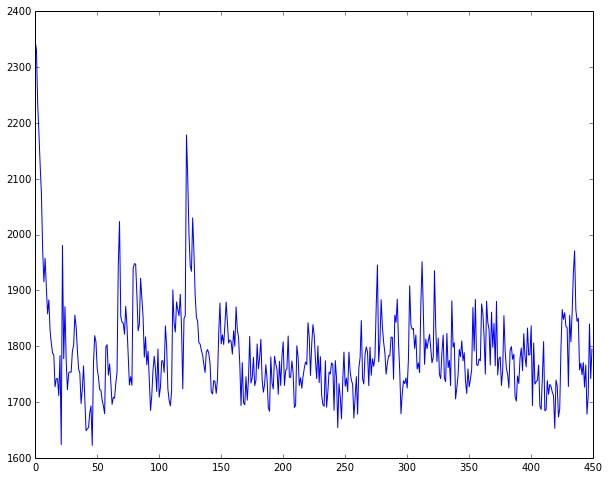

In [16]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
model.train(X_train, y_train)